# Settings

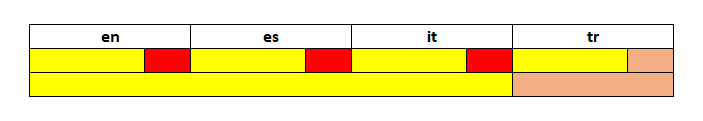

In [1]:
# CONTROLS
MODEL_PREFIX = "V10"
MODEL_NUMBER = MODEL_PREFIX[-2:]
MODEL_NAME = 'distilbert' # options include 'xlm' or 'distilbert'

NUM_EPOCHS = [4, 8, 2]
LR = 5e-4
MAX_SEQ_LEN = 75
SAMPLE_SIZE = 6000
PSUEDO_PROB_THRESH_LOW = 0.05
PSUEDO_PROB_THRESH_HIGH = 0.7

RUN_ON_SAMPLE = 0
if RUN_ON_SAMPLE>0:
    SAMPLE_SIZE = RUN_ON_SAMPLE

ON_KAGGLE = False

if ON_KAGGLE:
    BATCH_SIZE = 32
    PREDICT_BATCH_SIZE = 512
else:
    BATCH_SIZE = 16
    PREDICT_BATCH_SIZE = 256

TRAIN_SPLIT_RATIO = 0.2
DROPOUT = 0.3
LABEL_SMOOTHING_PARAM = 0.05

In [2]:
if ON_KAGGLE:
    RESULTS_DIR = '../working/'
    DATA_DIR = '../input/jigsaw-multilingual-toxic-comment-classification/'
    if MODEL_NAME == 'xlm':
        MODEL_DIR = '../input/tf-xlm-roberta-base/'
    else:
        MODEL_DIR = '../input/tf-distilbert-base-multilingual-cased/'
else:
    PATH = ".."
    RESULTS_DIR = PATH+"/results/"
    DATA_DIR = PATH+"/data/"
    if MODEL_NAME == 'xlm':
        MODEL_DIR = PATH+"/models/tf-xlm-roberta-base/"
    else:
        MODEL_DIR = PATH+"/models/distilbert-base-multilingual-cased/"

# Libraries

In [3]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, make_scorer
from sklearn.model_selection import StratifiedKFold, train_test_split, KFold, LeaveOneGroupOut, cross_val_score
from sklearn.utils import class_weight

import xgboost as xgb

from hyperopt import hp, tpe
from hyperopt.fmin import fmin

import pickle, os, sys, re, json, gc
from time import time, ctime
from pprint import pprint
from collections import Counter

import tensorflow as tf
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import Conv1D, Conv2D, LSTM, Embedding, Dense, concatenate, MaxPooling2D, Softmax, Flatten
from tensorflow.keras.layers import BatchNormalization, Dropout, Reshape, Activation, Bidirectional, TimeDistributed
from tensorflow.keras.layers import RepeatVector, Multiply, Layer, LeakyReLU, Subtract
from tensorflow.keras.activations import softmax
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import initializers, regularizers, constraints
from tensorflow.keras.callbacks import *
from tensorflow.keras.callbacks import CSVLogger, ModelCheckpoint
import tensorflow.keras.backend as K
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.models import save_model, load_model
from tensorflow.keras.utils import to_categorical

import tokenizers, transformers
from transformers import *

import tensorflow_addons as tfa
from tensorflow_addons.optimizers import TriangularCyclicalLearningRate

%matplotlib inline

In [4]:
seeded_value = 987258
pd.set_option('display.max_colwidth', None)
np.random.seed(seeded_value)
tf.random.set_seed(seeded_value)

In [5]:
print(ctime(time()))

Sat Jun 20 18:13:23 2020


In [6]:
print([
    tf.__version__,
    transformers.__version__,
    tokenizers.__version__
])

['2.1.0', '2.8.0', '0.5.2']


<a href="https://www.tensorflow.org/guide/gpu#limiting_gpu_memory_growth"  target="_blank"><h2 id="limiting_gpu_memory_growth" data-text="Limiting GPU memory growth" tabindex="0">Limiting GPU memory growth</h2></a>
<p>By default, TensorFlow maps nearly all of the GPU memory of all GPUs (subject to
<a href="https://docs.nvidia.com/cuda/cuda-c-programming-guide/index.html#env-vars"><code translate="no" dir="ltr">CUDA_VISIBLE_DEVICES</code></a>) visible to the process. This is done to more efficiently use the relatively precious GPU memory resources on the devices by reducing memory fragmentation. To limit TensorFlow to a specific set of GPUs we use the <code translate="no" dir="ltr">tf.config.experimental.set_visible_devices</code> method.</p>

In [7]:
print(tf.config.experimental.list_logical_devices('CPU'))
print(tf.config.experimental.list_logical_devices('GPU'))
print(tf.config.experimental.list_physical_devices('CPU'))
print(tf.config.experimental.list_physical_devices('GPU'))

[LogicalDevice(name='/device:CPU:0', device_type='CPU')]
[LogicalDevice(name='/device:GPU:0', device_type='GPU')]
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [8]:
physical_devices = tf.config.list_physical_devices('GPU')
try:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
    # Invalid device or cannot modify virtual devices once initialized.
    pass

# Import Data

In [9]:
train = pd.read_csv(DATA_DIR+'jigsaw-toxic-comment-train.csv')
validation = pd.read_csv(DATA_DIR+'validation.csv')
test = pd.read_csv(DATA_DIR+'test.csv')

In [10]:
train['lang'] = 'en'

train['set'] = 'train'
validation['set'] = 'valid'
test['set'] = 'test'

test['toxic'] = 0

In [11]:
print(train.columns)
print(validation.columns)
print(test.columns)

Index(['id', 'comment_text', 'toxic', 'severe_toxic', 'obscene', 'threat',
       'insult', 'identity_hate', 'lang', 'set'],
      dtype='object')
Index(['id', 'comment_text', 'lang', 'toxic', 'set'], dtype='object')
Index(['id', 'content', 'lang', 'set', 'toxic'], dtype='object')


In [12]:
validation.lang.unique(), test.lang.unique()

(array(['es', 'it', 'tr'], dtype=object),
 array(['tr', 'ru', 'it', 'fr', 'pt', 'es'], dtype=object))

In [13]:
train.columns = ['id', 'text', 'toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate', 'lang', 'set']
validation.columns = ['id', 'text', 'lang', 'toxic', 'set']
test.columns = ['id', 'text', 'lang', 'set', 'toxic']

In [14]:
REQ_COLS = ['id', 'set', 'text', 'lang', 'toxic']

In [15]:
train['text'] = train["text"].astype(str)
validation['text'] = validation["text"].astype(str)
test['text'] = test["text"].astype(str)

In [16]:
data = pd.concat([train[REQ_COLS].sample(SAMPLE_SIZE, random_state=seeded_value),
                  validation[REQ_COLS]], axis=0)

In [17]:
data.shape

(14000, 5)

In [18]:
data.sample(2)

,id,set,text,lang,toxic
164112,126f4ebe96739a72,train,""" \n\n *Support I have heard of the region before as Nakhichevan. \n *Support Nakhichevan is the common name of the area in English. """,en,0
4631,4631,valid,"¿Bastardilla?¿Pero no se decía cursiva?.Creo que sería mejor poner cursiva , en vez de bastardilla . Super",es,0


In [19]:
data.groupby(["set", "lang"]).agg({'id':'count', 'toxic':np.mean})

id     toxic
set   lang                
train en    6000  0.092667
valid es    2500  0.168800
      it    2500  0.195200
      tr    3000  0.106667

In [20]:
test.groupby(["set", "lang"]).agg({'id':'count', 'toxic':np.mean})

id  toxic
set  lang              
test es     8438      0
     fr    10920      0
     it     8494      0
     pt    11012      0
     ru    10948      0
     tr    14000      0

In [21]:
if RUN_ON_SAMPLE>0:
    data = data.sample(RUN_ON_SAMPLE).copy().reset_index(drop=True)
    test = test.sample(RUN_ON_SAMPLE).copy().reset_index(drop=True)

# Tokenizer, Config & Model Initialization

1. https://arxiv.org/pdf/1911.02116.pdf
2. https://huggingface.co/transformers/model_doc/xlmroberta.html

In [22]:
if MODEL_NAME == 'xlm':
    xlmr_tok = transformers.XLMRobertaTokenizer.from_pretrained(MODEL_DIR)
else:
    xlmr_tok = transformers.DistilBertTokenizer.from_pretrained(MODEL_DIR)

In [23]:
with open(MODEL_DIR+"special_tokens_map.json") as f:
    special_tokens = json.load(f)
xlmr_tok.add_special_tokens(special_tokens)

0

In [24]:
VOCAB_SIZE = xlmr_tok.vocab_size
print(VOCAB_SIZE)

119547


# Tokenization

In [25]:
X_tokens, X_att = [], []
for t in data.text.tolist():
    encoded_text = xlmr_tok.encode_plus(t, pad_to_max_length=True, max_length=MAX_SEQ_LEN)
    X_tokens.append(encoded_text['input_ids'])
    X_att.append(encoded_text['attention_mask'])

X_tokens, X_att, X_lang, Y_toxic = np.array(X_tokens), np.array(X_att), data['lang'].values, data['toxic'].values

In [26]:
X_tokens_test, X_att_test = [], []
for t in test.text.tolist():
    encoded_text = xlmr_tok.encode_plus(t, pad_to_max_length=True, max_length=MAX_SEQ_LEN)
    X_tokens_test.append(encoded_text['input_ids'])
    X_att_test.append(encoded_text['attention_mask'])

X_tokens_test, X_att_test, X_lang_test = np.array(X_tokens_test), np.array(X_att_test), test['lang'].values

print("\n",
      X_tokens_test.shape, "\t: X_tokens_test ", "\n",
      X_att_test.shape, "\t: X_att_test ", "\n"
)


 (63812, 75) 	: X_tokens_test  
 (63812, 75) 	: X_att_test  



In [27]:
if os.path.exists(DATA_DIR+"ProcessedData.pickle"):
    with open(DATA_DIR+"ProcessedData.pickle", "rb") as f:
        pickle.dump((X_tokens, X_att, X_lang, Y_toxic, X_tokens_test, X_att_test, X_lang_test), f)

In [28]:
if os.path.exists(DATA_DIR+"ProcessedData.pickle"):
    with open(DATA_DIR+"ProcessedData.pickle", "rb") as f:
        X_tokens, X_att, X_lang, Y_toxic, X_tokens_test, X_att_test, X_lang_test = pickle.load(f)

# Model Specifications

In [29]:
def build_model():
    input_sequences = Input((MAX_SEQ_LEN), dtype=tf.int32, name="words")
    input_att_flags = Input((MAX_SEQ_LEN), dtype=tf.int32, name="att_flags")
    
    if MODEL_NAME == 'xlm':
        config = transformers.XLMRobertaConfig.from_pretrained(MODEL_DIR)
        base_model = transformers.TFXLMRobertaModel.from_pretrained(MODEL_DIR, config=config) # TFXLMRobertaForSequenceClassification
        x = base_model(inputs=input_sequences, attention_mask=input_att_flags)
    else:
        config = transformers.DistilBertConfig.from_pretrained(MODEL_DIR)
        base_model = transformers.TFDistilBertModel.from_pretrained(MODEL_DIR) # TFDistilBertForSequenceClassification
        x = base_model(inputs=input_sequences, attention_mask=input_att_flags)
    
    x1 = tf.keras.layers.Dropout(DROPOUT)(x[0])
    x1 = tf.keras.layers.Conv1D(768, 2, padding='same')(x1)
    x1 = tf.keras.layers.BatchNormalization()(x1)
    x1 = tf.keras.layers.LeakyReLU()(x1)
    x1 = tf.keras.layers.Dense(1)(x1)
    x1 = tf.keras.layers.BatchNormalization()(x1)
    x1 = tf.keras.layers.LeakyReLU()(x1)
    x1 = tf.keras.layers.Flatten()(x1)
    x1 = tf.keras.layers.Dense(1)(x1)
    toxic_output = tf.keras.layers.Activation('sigmoid', name="toxic_output")(x1)
    
    model = Model([input_att_flags, input_sequences],
                  [toxic_output])
    
    base_model = Model([input_att_flags, input_sequences],
                       [x[0]])

    return model, base_model

In [30]:
model, base_model = build_model()

In [31]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
words (InputLayer)              [(None, 75)]         0                                            
__________________________________________________________________________________________________
att_flags (InputLayer)          [(None, 75)]         0                                            
__________________________________________________________________________________________________
tf_distil_bert_model (TFDistilB ((None, 75, 768),)   134734080   words[0][0]                      
__________________________________________________________________________________________________
dropout_19 (Dropout)            (None, 75, 768)      0           tf_distil_bert_model[0][0]       
______________________________________________________________________________________________

In [32]:
base_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
words (InputLayer)              [(None, 75)]         0                                            
__________________________________________________________________________________________________
att_flags (InputLayer)          [(None, 75)]         0                                            
__________________________________________________________________________________________________
tf_distil_bert_model (TFDistilB ((None, 75, 768),)   134734080   words[0][0]                      
Total params: 134,734,080
Trainable params: 134,734,080
Non-trainable params: 0
__________________________________________________________________________________________________


# Cross Validation Strategy

KFold Stratified train-validation split

In [33]:
#NUM_FOLDS = 3
#skf = StratifiedKFold(NUM_FOLDS, shuffle=True, random_state=seeded_value)

Leave one language out split

In [34]:
#logo = LeaveOneGroupOut()
#for t_index, v_index in logo.split(np.arange(X_tokens.shape[0]), np.arange(X_tokens.shape[0]), groups=X_lang):
#    print(X_lang[t_index])
#    #print(np.unique(X_lang[v_index]))

Simple random train-validation split

In [35]:
t_index, v_index = train_test_split(np.arange(X_tokens.shape[0]), shuffle=True, random_state=seeded_value)

# Model Fit

<a href="https://keras.io/guides/transfer_learning/#finetuning" target="_blank"><h2 id="finetuning">Fine-tuning</h2></a>
<p>Once your model has converged on the new data, you can try to unfreeze all or part of
 the base model and retrain the whole model end-to-end with a very low learning rate.</p>
 <p>This is an optional last step that can potentially give you incremental improvements.
 It could also potentially lead to quick overfitting -- keep that in mind.</p>
 <p>It is critical to only do this step <em>after</em> the model with frozen layers has been
trained to convergence. If you mix randomly-initialized trainable layers with
trainable layers that hold pre-trained features, the randomly-initialized layers will
cause very large gradient updates during training, which will destroy your pre-trained
 features.</p>
 <p>It's also critical to use a very low learning rate at this stage, because
you are training a much larger model than in the first round of training, on a dataset
 that is typically very small.
As a result, you are at risk of overfitting very quickly if you apply large weight
 updates. Here, you only want to readapt the pretrained weights in an incremental way.</p>

<a href="https://keras.io/guides/transfer_learning/#finetuning" target="_blank"><p><strong>Important note about <code>compile()</code> and <code>trainable</code></strong></p></a>
<p>Calling <code>compile()</code> on a model is meant to "freeze" the behavior of that model. This
 implies that the <code>trainable</code>
attribute values at the time the model is compiled should be preserved throughout the
 lifetime of that model,
until <code>compile</code> is called again. Hence, if you change any <code>trainable</code> value, make sure
 to call <code>compile()</code> again on your
model for your changes to be taken into account.</p>

In [36]:
pred = np.zeros((len(X_tokens), 1))
pred_test = np.zeros((len(X_tokens_test), 1))
timings_dict = {}

In [37]:
num=0
valid_lang='all'
start_time = time()

if num>0:
    del model
    del mcp
    del csvl
    del adam
    del history
    del auc
    gc.collect()
    K.clear_session()

model, base_model = build_model()
auc = tf.keras.metrics.AUC()
mcp = ModelCheckpoint(filepath=RESULTS_DIR+MODEL_PREFIX+"BestCheckpoint_"+valid_lang+"_"+str(num)+".h5", monitor='val_auc',
                      verbose=0, save_best_only=True, save_weights_only=True, mode='max', save_freq='epoch')
csvl = CSVLogger(filename=RESULTS_DIR+MODEL_PREFIX+"_LossLogs_"+valid_lang+"_"+str(num)+".csv",
                 separator=",", append=True)

model.layers[2].trainable = False
adam = Adam(learning_rate=LR)
model.compile(loss={"toxic_output":tf.keras.losses.BinaryCrossentropy(label_smoothing=LABEL_SMOOTHING_PARAM)},
              optimizer=adam,
              metrics=['accuracy', auc])

train_time = time()
history = model.fit(x={"att_flags":X_att[t_index],
                       "words":X_tokens[t_index]},
                    y={"toxic_output":Y_toxic[t_index]},
                    validation_data=({"att_flags":X_att[v_index],
                                      "words":X_tokens[v_index]},
                                     {"toxic_output":Y_toxic[v_index]}),
                    batch_size=BATCH_SIZE,
                    epochs=NUM_EPOCHS[0],
                    shuffle=True,
                    verbose=1, 
                    sample_weight=class_weight.compute_sample_weight('balanced',X_lang[t_index]),
                    callbacks=[csvl])

  ...
    to  
  ['...']
Train on 10500 samples, validate on 3500 samples
Epoch 1/4
10500/10500 [==============================] - 67s 6ms/sample - loss: 0.4086 - accuracy: 0.8689 - auc: 0.7529 - val_loss: 0.3645 - val_accuracy: 0.8771 - val_auc: 0.8185
Epoch 2/4
10500/10500 [==============================] - 56s 5ms/sample - loss: 0.3645 - accuracy: 0.8836 - auc: 0.8380 - val_loss: 0.3504 - val_accuracy: 0.8811 - val_auc: 0.8524
Epoch 3/4
10500/10500 [==============================] - 56s 5ms/sample - loss: 0.3546 - accuracy: 0.8890 - auc: 0.8532 - val_loss: 0.3525 - val_accuracy: 0.8809 - val_auc: 0.8438
Epoch 4/4
10500/10500 [==============================] - 56s 5ms/sample - loss: 0.3478 - accuracy: 0.8926 - auc: 0.8622 - val_loss: 0.3373 - val_accuracy: 0.8894 - val_auc: 0.8616


In [38]:
pred_initial = model.predict(x = {"att_flags":X_att,
                                  "words":X_tokens},
                             batch_size=PREDICT_BATCH_SIZE)

print("Train ROC-AUC:\t", roc_auc_score(y_true=Y_toxic[t_index], y_score=pred_initial[t_index]))
print("Valid ROC-AUC:\t", roc_auc_score(y_true=Y_toxic[v_index], y_score=pred_initial[v_index]))

print("Train Accuracy:\t", accuracy_score(y_true=Y_toxic[t_index], y_pred=np.where(pred_initial[t_index]>0.5, 1, 0)))
print("Valid Accuracy:\t", accuracy_score(y_true=Y_toxic[v_index], y_pred=np.where(pred_initial[v_index]>0.5, 1, 0)))

print(classification_report(y_true=Y_toxic[t_index], y_pred=np.where(pred_initial[t_index]>0.5, 1, 0)))
print(classification_report(y_true=Y_toxic[v_index], y_pred=np.where(pred_initial[v_index]>0.5, 1, 0)))

Train ROC-AUC:	 0.9013097266084913
Valid ROC-AUC:	 0.8617155282724736
Train Accuracy:	 0.9031428571428571
Valid Accuracy:	 0.8894285714285715
              precision    recall  f1-score   support

           0       0.92      0.97      0.95      9176
           1       0.69      0.42      0.52      1324

    accuracy                           0.90     10500
   macro avg       0.80      0.70      0.74     10500
weighted avg       0.89      0.90      0.89     10500

              precision    recall  f1-score   support

           0       0.91      0.97      0.94      3038
           1       0.63      0.39      0.48       462

    accuracy                           0.89      3500
   macro avg       0.77      0.68      0.71      3500
weighted avg       0.88      0.89      0.88      3500



In [39]:
# Psuedo model fit
psuedo_time = time()

# Accumulate test results after training every fold
pred_psuedo = model.predict(x = {"att_flags":X_att_test,
                                 "words":X_tokens_test},
                            batch_size=PREDICT_BATCH_SIZE).reshape((-1))

In [40]:
test['toxic_1'] = pred_psuedo

In [41]:
test['toxic_1'].describe()

count    63812.000000
mean         0.188803
std          0.199487
min          0.000529
25%          0.038880
50%          0.110128
75%          0.275189
max          0.949988
Name: toxic_1, dtype: float64

In [42]:
test.groupby(["set", "lang"]).agg({'id':'count', 'toxic_1':np.mean})

id   toxic_1
set  lang                 
test es     8438  0.248041
     fr    10920  0.308150
     it     8494  0.210303
     pt    11012  0.120315
     ru    10948  0.125336
     tr    14000  0.150472

In [43]:
test.groupby(["set", "lang"])[['toxic_1']].apply(pd.Series.describe)

toxic_1
set  lang                    
test es   count   8438.000000
          mean       0.248041
          std        0.236975
          min        0.000865
          25%        0.056279
          50%        0.156498
          75%        0.381731
          max        0.929942
     fr   count  10920.000000
          mean       0.308150
          std        0.218372
          min        0.002009
          25%        0.124900
          50%        0.261886
          75%        0.455986
          max        0.949988
     it   count   8494.000000
          mean       0.210303
          std        0.191497
          min        0.000968
          25%        0.057510
          50%        0.146646
          75%        0.315850
          max        0.916670
     pt   count  11012.000000
          mean       0.120315
          std        0.163379
          min        0.000529
          25%        0.017255
          50%        0.051129
          75%        0.149998
          max        0.902359
     ru   count  10948.000000
          mean       0.125336
          std        0.140617
          min        0.001007
          25%        0.031395
          50%        0.072802
          75%        0.164836
          max        0.880950
     tr   count  14000.000000
          mean       0.150472
          std        0.172732
          min        0.000715
          25%        0.031579
          50%        0.080276
          75%        0.203653
          max        0.893340

In [44]:
Y_toxic_psuedo = np.where(pred_psuedo >= PSUEDO_PROB_THRESH_HIGH, 1, 0)
psuedo_flag = (pred_psuedo >= PSUEDO_PROB_THRESH_HIGH) | (pred_psuedo <= PSUEDO_PROB_THRESH_LOW)

print("Number of psuedo samples available:", sum(psuedo_flag))
print("Psuedo Toxicity:", sum(Y_toxic_psuedo))
print(Counter(test.lang.values))
print(Counter(test.lang.values[psuedo_flag]))

X_att_psuedo = np.concatenate((X_att[t_index], X_att_test[psuedo_flag]))
X_tokens_psuedo = np.concatenate((X_tokens[t_index], X_tokens_test[psuedo_flag]))
Y_toxic_psuedo = np.concatenate((Y_toxic[t_index], Y_toxic_psuedo[psuedo_flag]))
X_lang_psuedo = np.concatenate((X_lang[t_index], X_lang_test[psuedo_flag]))

shuffled_idxs = np.arange(Y_toxic_psuedo.shape[0])
np.random.shuffle(shuffled_idxs)

model.layers[2].trainable = False
adam = Adam(learning_rate=LR)
model.compile(loss={"toxic_output":tf.keras.losses.BinaryCrossentropy(label_smoothing=LABEL_SMOOTHING_PARAM)},
              optimizer=adam,
              metrics=['accuracy', auc])

history = model.fit(x={"att_flags":X_att_psuedo[shuffled_idxs],
                       "words":X_tokens_psuedo[shuffled_idxs]},
                    y={"toxic_output":Y_toxic_psuedo[shuffled_idxs]},
                    validation_data=({"att_flags":X_att[v_index],
                                      "words":X_tokens[v_index]},
                                     {"toxic_output":Y_toxic[v_index]}),
                    batch_size=BATCH_SIZE,
                    epochs=NUM_EPOCHS[1],
                    shuffle=True,
                    verbose=1,
                    callbacks=[mcp, csvl], 
                    sample_weight=class_weight.compute_sample_weight('balanced',X_lang_psuedo[shuffled_idxs]))

if NUM_EPOCHS[2]>0:
    model.layers[2].trainable = True
    adam = Adam(learning_rate=LR*0.001)
    model.compile(loss={"toxic_output":tf.keras.losses.BinaryCrossentropy(label_smoothing=LABEL_SMOOTHING_PARAM)},
                  optimizer=adam,
                  metrics=['accuracy', auc])

    history = model.fit(x={"att_flags":X_att_psuedo[shuffled_idxs],
                           "words":X_tokens_psuedo[shuffled_idxs]},
                        y={"toxic_output":Y_toxic_psuedo[shuffled_idxs]},
                        validation_data=({"att_flags":X_att[v_index],
                                          "words":X_tokens[v_index]},
                                         {"toxic_output":Y_toxic[v_index]}),
                        batch_size=BATCH_SIZE,
                        epochs=NUM_EPOCHS[2],
                        shuffle=True,
                        verbose=1,
                        callbacks=[mcp, csvl], 
                        sample_weight=class_weight.compute_sample_weight('balanced',X_lang_psuedo[shuffled_idxs]))

Number of psuedo samples available: 21548
Psuedo Toxicity: 2189
Counter({'tr': 14000, 'pt': 11012, 'ru': 10948, 'fr': 10920, 'it': 8494, 'es': 8438})
Counter({'pt': 5658, 'tr': 5403, 'ru': 4298, 'es': 2593, 'it': 2087, 'fr': 1509})
  ...
    to  
  ['...']
Train on 32048 samples, validate on 3500 samples
Epoch 1/8
32048/32048 [==============================] - 120s 4ms/sample - loss: 0.2033 - accuracy: 0.9626 - auc: 0.9740 - val_loss: 0.3484 - val_accuracy: 0.8851 - val_auc: 0.8593
Epoch 2/8
32048/32048 [==============================] - 115s 4ms/sample - loss: 0.1982 - accuracy: 0.9638 - auc: 0.9754 - val_loss: 0.3456 - val_accuracy: 0.8857 - val_auc: 0.8700
Epoch 3/8
32048/32048 [==============================] - 116s 4ms/sample - loss: 0.1954 - accuracy: 0.9643 - auc: 0.9773 - val_loss: 0.3625 - val_accuracy: 0.8769 - val_auc: 0.8701
Epoch 4/8
32048/32048 [==============================] - 115s 4ms/sample - loss: 0.1932 - accuracy: 0.9646 - auc: 0.9793 - val_loss: 0.3495 - val_accur

In [45]:
infer_time = time()

# Loading best weights per fold
model.load_weights(RESULTS_DIR+MODEL_PREFIX+"BestCheckpoint_"+valid_lang+"_"+str(num)+".h5")

pred += model.predict(x = {"att_flags":X_att,
                                "words":X_tokens},
                           batch_size=PREDICT_BATCH_SIZE)

pred_psuedo = model.predict(x = {"att_flags":X_att_psuedo,
                                 "words":X_tokens_psuedo},
                            batch_size=PREDICT_BATCH_SIZE)

print("Train ROC-AUC:\t", roc_auc_score(y_true=Y_toxic[t_index], y_score=pred[t_index]))
print("Valid ROC-AUC:\t", roc_auc_score(y_true=Y_toxic[v_index], y_score=pred[v_index]))

print("Train Accuracy:\t", accuracy_score(y_true=Y_toxic[t_index], y_pred=np.where(pred[t_index]>0.5, 1, 0)))
print("Valid Accuracy:\t", accuracy_score(y_true=Y_toxic[v_index], y_pred=np.where(pred[v_index]>0.5, 1, 0)))

print(classification_report(y_true=Y_toxic[t_index], y_pred=np.where(pred[t_index]>0.5, 1, 0)))
print(classification_report(y_true=Y_toxic[v_index], y_pred=np.where(pred[v_index]>0.5, 1, 0)))

# Accumulate test results after training every fold

pred_test += model.predict(x = {"att_flags":X_att_test,
                                "words":X_tokens_test},
                           batch_size=PREDICT_BATCH_SIZE)

end_time = time()
timings_dict.update({num:{
    'start_time' : ctime(start_time),
    'train_time' : ctime(train_time),
    'infer_time' : ctime(infer_time),
    'psuedo_time' : ctime(psuedo_time),
    'end_time' : ctime(end_time),
}})

Train ROC-AUC:	 0.9379211037857855
Valid ROC-AUC:	 0.8848980731798375
Train Accuracy:	 0.9160952380952381
Valid Accuracy:	 0.8934285714285715
              precision    recall  f1-score   support

           0       0.94      0.97      0.95      9176
           1       0.72      0.55      0.62      1324

    accuracy                           0.92     10500
   macro avg       0.83      0.76      0.79     10500
weighted avg       0.91      0.92      0.91     10500

              precision    recall  f1-score   support

           0       0.93      0.95      0.94      3038
           1       0.62      0.49      0.55       462

    accuracy                           0.89      3500
   macro avg       0.77      0.72      0.74      3500
weighted avg       0.89      0.89      0.89      3500



In [46]:
pd.DataFrame.from_dict(timings_dict)

,0
end_time,Sat Jun 20 18:55:06 2020
infer_time,Sat Jun 20 18:50:39 2020
psuedo_time,Sat Jun 20 18:20:18 2020
start_time,Sat Jun 20 18:15:46 2020
train_time,Sat Jun 20 18:15:49 2020


In [47]:
test['toxic'] = pred_test

In [64]:
test[['id','toxic']].to_csv(RESULTS_DIR+"submission.csv", index=False)
test.to_csv(RESULTS_DIR+"all_results.csv", index=False)

In [49]:
test['toxic'].describe()

count    63812.000000
mean         0.223970
std          0.279298
min          0.000910
25%          0.030521
50%          0.088178
75%          0.309262
max          0.999762
Name: toxic, dtype: float64

In [50]:
test.groupby(["set", "lang"]).agg({'id':'count', 'toxic':np.mean})

id     toxic
set  lang                 
test es     8438  0.293859
     fr    10920  0.445883
     it     8494  0.238690
     pt    11012  0.149391
     ru    10948  0.122042
     tr    14000  0.138193

In [51]:
test.groupby(["set", "lang"])[['toxic', 'toxic_1']].apply(pd.Series.describe)

toxic       toxic_1
set  lang                                  
test es   count   8438.000000   8438.000000
          mean       0.293859      0.248041
          std        0.312769      0.236975
          min        0.002746      0.000865
          25%        0.051409      0.056279
          50%        0.147622      0.156498
          75%        0.455756      0.381731
          max        0.997260      0.929942
     fr   count  10920.000000  10920.000000
          mean       0.445883      0.308150
          std        0.342267      0.218372
          min        0.002208      0.002009
          25%        0.111377      0.124900
          50%        0.385216      0.261886
          75%        0.784554      0.455986
          max        0.999762      0.949988
     it   count   8494.000000   8494.000000
          mean       0.238690      0.210303
          std        0.243598      0.191497
          min        0.001306      0.000968
          25%        0.054607      0.057510
          50%        0.142983      0.146646
          75%        0.348909      0.315850
          max        0.991881      0.916670
     pt   count  11012.000000  11012.000000
          mean       0.149391      0.120315
          std        0.226185      0.163379
          min        0.001138      0.000529
          25%        0.021393      0.017255
          50%        0.046624      0.051129
          75%        0.160955      0.149998
          max        0.994422      0.902359
     ru   count  10948.000000  10948.000000
          mean       0.122042      0.125336
          std        0.179413      0.140617
          min        0.001692      0.001007
          25%        0.023257      0.031395
          50%        0.050391      0.072802
          75%        0.131782      0.164836
          max        0.987605      0.880950
     tr   count  14000.000000  14000.000000
          mean       0.138193      0.150472
          std        0.206122      0.172732
          min        0.000910      0.000715
          25%        0.020184      0.031579
          50%        0.049187      0.080276
          75%        0.150358      0.203653
          max        0.989695      0.893340

In [52]:
print(ctime(time()))

Sat Jun 20 18:55:07 2020


### No Gain using XGBoost

In [53]:
features = base_model.predict(x={"att_flags":X_att_psuedo,
                                 "words":X_tokens_psuedo},
                              batch_size=PREDICT_BATCH_SIZE).mean(axis=2)
features = np.concatenate((features, pred_psuedo), axis=1)

In [54]:
features_valid = base_model.predict(x={"att_flags":X_att[v_index],
                                       "words":X_tokens[v_index]},
                              batch_size=PREDICT_BATCH_SIZE).mean(axis=2)
features_valid = np.concatenate((features_valid, pred[v_index]), axis=1)

In [55]:
features_test = base_model.predict(x={"att_flags":X_att_test,
                                      "words":X_tokens_test},
                                   batch_size=PREDICT_BATCH_SIZE).mean(axis=2)
features_test = np.concatenate((features_test, pred_test), axis=1)

In [56]:
NUM_TREES = 10
NUM_CLASSES = 2
NUM_EVALS = 25
NUM_FOLDS=3

auc_scorer = make_scorer(roc_auc_score, greater_is_better=True, needs_proba=False)

In [57]:
def objective(params):
    params = {
        'max_depth': int(params['max_depth']),
        'gamma': "{:.3f}".format(params['gamma']),
        'colsample_bytree': '{:.3f}'.format(params['colsample_bytree']),
    }

    clf = xgb.XGBClassifier(
        n_estimators=NUM_TREES,
        verbosity=1,
        objective="binary:logistic",
        random_state=seeded_value, 
        booster='gbtree',
        n_jobs=12,
        **params
    )

    #score = cross_val_score(estimator=clf,
    #                        X=features,
    #                        y=Y_toxic_psuedo,
    #                        scoring=auc_scorer,
    #                        cv=StratifiedKFold(n_splits=NUM_FOLDS,
    #                                           shuffle=True,
    #                                           random_state=seeded_value)).mean()
    
    clf.fit(X=features, y=Y_toxic_psuedo)
    preds = clf.predict(features_valid)
    score = roc_auc_score(y_true=Y_toxic[v_index], y_score=preds)
    
    print("AUC Score {:.3f} params {}".format(score, params))
    return -1.0*score

In [58]:
space = {
    'max_depth': hp.quniform('max_depth', 2, 8, 1),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.3, 1.0),
    'gamma': hp.uniform('gamma', 0.0, 0.5),
}

best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=NUM_EVALS)

optimal_params = {
        'max_depth': int(best['max_depth']),
        'gamma': "{:.3f}".format(best['gamma']),
        'colsample_bytree': '{:.3f}'.format(best['colsample_bytree'])
}

print("***Best Parameters:", optimal_params, "***")

AUC Score 0.681 params {'max_depth': 6, 'gamma': '0.181', 'colsample_bytree': '0.648'}                                                                     
AUC Score 0.555 params {'max_depth': 7, 'gamma': '0.101', 'colsample_bytree': '0.489'}                                                                     
AUC Score 0.714 params {'max_depth': 6, 'gamma': '0.379', 'colsample_bytree': '0.772'}                                                                     
AUC Score 0.712 params {'max_depth': 7, 'gamma': '0.287', 'colsample_bytree': '0.817'}                                                                     
AUC Score 0.554 params {'max_depth': 7, 'gamma': '0.490', 'colsample_bytree': '0.464'}                                                                     
AUC Score 0.568 params {'max_depth': 6, 'gamma': '0.342', 'colsample_bytree': '0.514'}                                                                     
AUC Score 0.570 params {'max_depth': 4, 'gamma': '0.208', 'colsa

In [59]:
xgb_model = xgb.XGBClassifier(**{
    "n_estimators":NUM_TREES,
    "verbosity":1,
    "objective":"binary:logistic",
    "random_state":seeded_value,
    'booster':'gbtree',
    "n_jobs":12,
    **optimal_params
})

In [60]:
xgb_model.fit(X=features, y=Y_toxic_psuedo)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree='0.973', gamma='0.423',
              gpu_id=-1, importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=2,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=10, n_jobs=12, num_parallel_tree=1,
              objective='binary:logistic', random_state=987258, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=1)

In [61]:
pred_xgb = xgb_model.predict(features)
pred_xgb_valid = xgb_model.predict(features_valid)
pred_xgb_test = xgb_model.predict(features_test)

In [62]:
print("Psued ROC-AUC:\t", roc_auc_score(y_true=Y_toxic_psuedo, y_score=pred_xgb))
print("Valid ROC-AUC:\t", roc_auc_score(y_true=Y_toxic[v_index], y_score=pred_xgb_valid))

print("Psued Accuracy:\t", accuracy_score(y_true=Y_toxic_psuedo, y_pred=np.where(pred_xgb>0.5, 1, 0)))
print("Valid Accuracy:\t", accuracy_score(y_true=Y_toxic[v_index], y_pred=np.where(pred_xgb_valid>0.5, 1, 0)))

print(classification_report(y_true=Y_toxic_psuedo, y_pred=np.where(pred_xgb>0.5, 1, 0)))
print(classification_report(y_true=Y_toxic[v_index], y_pred=np.where(pred_xgb_valid>0.5, 1, 0)))

Psued ROC-AUC:	 0.9153086253860664
Valid ROC-AUC:	 0.7299010513296228
Psued Accuracy:	 0.9729780329505742
Valid Accuracy:	 0.8911428571428571
              precision    recall  f1-score   support

           0       0.98      0.99      0.98     28535
           1       0.91      0.84      0.87      3513

    accuracy                           0.97     32048
   macro avg       0.94      0.92      0.93     32048
weighted avg       0.97      0.97      0.97     32048

              precision    recall  f1-score   support

           0       0.93      0.95      0.94      3038
           1       0.60      0.51      0.55       462

    accuracy                           0.89      3500
   macro avg       0.77      0.73      0.75      3500
weighted avg       0.88      0.89      0.89      3500



In [63]:
{l:k for k,l in zip(xgb_model.feature_importances_, ['MODEL_'+str(i) for i in range(MAX_SEQ_LEN)]+['PsuedoScore'])}

{'MODEL_0': 0.0,
 'MODEL_1': 0.0,
 'MODEL_2': 0.0,
 'MODEL_3': 0.0,
 'MODEL_4': 0.0,
 'MODEL_5': 0.0,
 'MODEL_6': 0.0,
 'MODEL_7': 0.0,
 'MODEL_8': 0.0,
 'MODEL_9': 0.0,
 'MODEL_10': 0.0,
 'MODEL_11': 0.0,
 'MODEL_12': 0.0,
 'MODEL_13': 0.0,
 'MODEL_14': 0.0,
 'MODEL_15': 0.0,
 'MODEL_16': 0.0,
 'MODEL_17': 0.0,
 'MODEL_18': 0.0,
 'MODEL_19': 0.0,
 'MODEL_20': 0.0,
 'MODEL_21': 0.0,
 'MODEL_22': 0.0,
 'MODEL_23': 0.0,
 'MODEL_24': 0.0,
 'MODEL_25': 0.0,
 'MODEL_26': 0.0,
 'MODEL_27': 0.0,
 'MODEL_28': 0.0,
 'MODEL_29': 0.0,
 'MODEL_30': 0.0,
 'MODEL_31': 0.0,
 'MODEL_32': 0.0,
 'MODEL_33': 0.0,
 'MODEL_34': 0.0,
 'MODEL_35': 0.0,
 'MODEL_36': 0.0,
 'MODEL_37': 0.0,
 'MODEL_38': 0.0,
 'MODEL_39': 0.0,
 'MODEL_40': 0.0,
 'MODEL_41': 0.0,
 'MODEL_42': 0.0,
 'MODEL_43': 0.0,
 'MODEL_44': 0.0,
 'MODEL_45': 0.0,
 'MODEL_46': 0.0,
 'MODEL_47': 0.0,
 'MODEL_48': 0.0,
 'MODEL_49': 0.0,
 'MODEL_50': 0.0,
 'MODEL_51': 0.0,
 'MODEL_52': 0.0,
 'MODEL_53': 0.0,
 'MODEL_54': 0.0,
 'MODEL_55': 0.0,
 '